# Imports

In [677]:
import numpy as np
import os
import math
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv
import json
from scipy.stats import wasserstein_distance
import statistics
from tqdm import tqdm
import shutil
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt

# Data Loading Functions

In [487]:
def read_stats_data(name, mechanics, folder):
    data = {}
    for mech in mechanics:
        data[mech] = []
    data["EndTurn"] = []
    file_names = [f for f in os.listdir(folder) if name in f]
    for fn in file_names:
        with open(os.path.join(folder,fn)) as f:
            json_data = json.load(f)
            if "results" in json_data:
                json_data = json_data["results"]
            for playtrace in json_data:
                for mech in mechanics:
                    if mech in playtrace["frequencies"]:
                        data[mech].append(playtrace["frequencies"][mech])
                    else:
                        data[mech].append(0.0)
                data["EndTurn"].append(playtrace["levelReport"]["turnsTaken"])
    return pd.DataFrame(data)

def build_users_data(folder, mechanics, users):
    full_data = read_stats_data(users[0], mechanics, folder)
    full_data['id'] = users[0]
    for user in users[1:]:
        user_data = read_stats_data(user, mechanics, folder)
        user_data['id'] = user
        full_data = pd.concat([full_data, user_data])
    full_data.set_index('id', inplace=True)
    return full_data

def read_questionaire(users, classes, scores, folder):
    data = {}
    for key in classes:
        data[key] = []
    data['id'] = []
    for user in users:
        data['id'].append(user)
        with open(os.path.join(folder, user + ".json")) as f:
            json_data = json.load(f)
            if "Q1" in json_data:
                for key in classes:
                    data[key].append(0.0)
                    for q in classes[key]:
                        data[key][-1] += scores[json_data[q]]
                    data[key][-1] /= len(classes[key])
    df = pd.DataFrame(data)
    df.set_index('id', inplace=True)
    return df

# Helper Functions

In [664]:
def get_mechanics(folders):
    uniques = set()
    for folder in folders:
        filenames = [f for f in os.listdir(folder) if ".json" in f]
        for fn in filenames:
            with open(os.path.join(folder,fn)) as f:
                json_data = json.load(f)
                if "results" in json_data:
                    json_data = json_data["results"]
                for playtrace in json_data:
                    for key in playtrace["frequencies"].keys():
                        uniques.add(key)
    return list(uniques)

def get_users(folders):
    uniques = set()
    for folder in folders:
        filenames = [f for f in os.listdir(folder) if ".json" in f]
        for fn in filenames:
            uuid = fn.split(".")[0]
            uniques.add(uuid)
    return list(uniques)

def get_majority_voting(clf, data):
    labels = clf.predict(data).reshape((-1,3))
    result = []
    for row in labels:
        vals,counts= np.unique(row, return_counts=True)
        index = np.argmax(counts)
        result.append(vals[index])
    return np.array(result)

def divide_data_set(input_data, output_data, percentage):
    indeces = list(range(len(input_data)))
    random.shuffle(indeces)
    size = int(percentage * len(indeces))
    train_set, train_label, val_data, val_label = [],[],[],[]
    for i in range(size):
        train_set.append(input_data[indeces[i]])
        train_label.append(output_data[indeces[i]])
    for i in range(size,len(indeces)):
        val_data.append(input_data[indeces[i]]) 
        val_label.append(output_data[indeces[i]])
    return np.array(train_set), np.array(train_label), np.array(val_data), np.array(val_label)

def filter_traces(data, column, value, IsUser=None):
    remove_columns = (data.columns != 'IsUser') & (data.columns != 'Label')
    if column != 'index':
        filter_values = data[column] == value
        if IsUser != None:
            filter_values = filter_values & (data["IsUser"] == IsUser)
        return data.loc[filter_values, remove_columns]
    else:
        new_data = data[data.index == value]
        filter_values = [True] * len(new_data)
        if IsUser != None:
            filter_values = filter_values & (new_data["IsUser"] == IsUser)
        return new_data.loc[filter_values, remove_columns]

def calc_mech_importance(fil_data, all_data, mech):
    fil_array = fil_data[mech].to_numpy()
    all_array = all_data[mech].to_numpy()
    sign = np.sign(fil_array.mean() - all_array.mean())
    if sign == 0:
        sign = 1
    value = wasserstein_distance(fil_array, all_array)
    return sign * value

def calc_mech_axis(data, column, values, mechanics):
    value_temp = {}
    row_index = []
    for mech in mechanics:
        value_temp[mech] = []
        for v in values:
            traces = filter_traces(data, column, v)
            if len(traces) > 0:
                value_temp[mech].append(calc_mech_importance(traces, data, mech))
                if v not in row_index:
                    row_index.append(v)
    return pd.DataFrame(value_temp, index=row_index)

# Building Data

In [615]:
mechanics = get_mechanics(["results", "results_study"])
users = get_users(["results_study"])
classes = {
    "MK": ["Q5", "Q6", "Q10"],
    "TC": ["Q3", "Q4", "Q8"],
    "R": ["Q2", "Q7", "Q9"]
}
scores = {
    "Never": 0, 
    "Rarely": 1, 
    "Sometimes": 2, 
    "Often": 3, 
    "Always": 4
}
labels = {
    "MK": 0,
    "TC": 1,
    "R": 2
}
kill_mechanics = ["OgreHit", "GoblinMeleeHit", "GoblinRangedHit", "BlobHit"]

# Reading all the data file
mk_data = read_stats_data("MK", mechanics, "results")
tc_data = read_stats_data("TC", mechanics, "results")
r_data = read_stats_data("R", mechanics, "results")
user_data = build_users_data("results_study", mechanics, users)
ques_data = read_questionaire(users, classes, scores, "results_study")

# Removing User Data that didn't do any of the questionaire
user_filter = ques_data['MK'] + ques_data['TC'] + ques_data['R'] > 0
user_indeces = ques_data.index[user_filter]

user_data = user_data.loc[user_indeces]
ques_data = ques_data.loc[user_indeces]

TypeError: list indices must be integers or slices, not Index

# Combine All Data

In [570]:
temp_data = mk_data.copy()
temp_data["Label"] = "MK"
temp_data["IsUser"] = False
total_data = pd.concat([temp_data], ignore_index=True)
temp_data = tc_data.copy()
temp_data["Label"] = "TC"
temp_data["IsUser"] = False
total_data = pd.concat([total_data, temp_data], ignore_index=True)
temp_data = r_data.copy()
temp_data["Label"] = "R"
temp_data["IsUser"] = False
total_data = pd.concat([total_data, temp_data], ignore_index=True)
temp_data = user_data.copy()
temp_data["Label"] = ""
temp_data["IsUser"] = True

total_data = pd.concat([total_data, temp_data])
total_data["EnemyKill"] = 0
for kill in kill_mechanics:
    total_data["EnemyKill"] += total_data[kill]
    
for col in total_data.columns:
    if col == "Label" or col == "IsUser":
        continue
    total_data[col] /= 1.0 * total_data[col].max()

# Building Data Set

In [384]:
input_data = pd.concat([mk_data, tc_data, r_data], ignore_index=True).to_numpy()
output_data = pd.Series([0]*len(mk_data) + [1]*len(tc_data) + [2]*len(r_data)).to_numpy()
avg_test_set = user_data.groupby('id').mean().to_numpy()
maj_test_set = user_data.to_numpy()
ques_set = ques_data.to_numpy()

total_set = np.concatenate((input_data, avg_test_set, maj_test_set)) 

n_input_data = input_data / total_set.max(axis=0)
n_avg_test_set = avg_test_set / total_set.max(axis=0)
n_maj_test_set = maj_test_set / total_set.max(axis=0)
n_ques_set = ques_set / ques_set.sum(axis=1).reshape(-1,1).repeat(3, axis=1)

# Training Classifier

In [407]:
train_data,train_label,val_data,val_label = divide_data_set(n_input_data, output_data, 0.7)

dt = tree.DecisionTreeClassifier(max_depth=5)
dt = dt.fit(train_data, train_label)
print(f"Decision Tree Training Score: {dt.score(train_data, train_label)}")
print(f"Decision Tree Validation Score: {dt.score(val_data, val_label)}\n")

knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(train_data, train_label)
print(f"K Nearest Neighbor Training Score: {knn.score(train_data, train_label)}")
print(f"K Nearest Neighbor Validation Score: {knn.score(val_data, val_label)}\n")

svc = svm.SVC(decision_function_shape='ovo', probability=True)
svc = svc.fit(train_data, train_label)
print(f"Support Vector Machine Training Score: {svc.score(train_data, train_label)}")
print(f"Support Vector Machine Validation Score: {svc.score(val_data, val_label)}")

Decision Tree Training Score: 0.8328571428571429
Decision Tree Validation Score: 0.8144444444444444

K Nearest Neighbor Training Score: 0.909047619047619
K Nearest Neighbor Validation Score: 0.84

Support Vector Machine Training Score: 0.8471428571428572
Support Vector Machine Validation Score: 0.8377777777777777


# Predicting Users

In [408]:
dt_avg_probs = dt.predict_proba(n_avg_test_set)
knn_avg_probs = knn.predict_proba(n_avg_test_set)
svc_avg_probs = svc.predict_proba(n_avg_test_set)

dt_avg_labels = dt.predict(n_avg_test_set)
knn_avg_labels = knn.predict(n_avg_test_set)
svc_avg_labels = svc.predict(n_avg_test_set)

print(f"Average DT vs KNN: {(dt_avg_labels == knn_avg_labels).sum()/len(avg_test_set)}")
print(f"Average DT vs SVC: {(dt_avg_labels == svc_avg_labels).sum()/len(avg_test_set)}")
print(f"Average KNN vs SVC: {(knn_avg_labels == svc_avg_labels).sum()/len(avg_test_set)}")

dt_maj_labels = get_majority_voting(dt, n_maj_test_set)
knn_maj_labels = get_majority_voting(knn, n_maj_test_set)
svc_maj_labels = get_majority_voting(svc, n_maj_test_set)

dt_maj_probs = dt.predict_proba(n_maj_test_set).reshape((-1,3,3)).mean(axis=1)
knn_maj_probs = knn.predict_proba(n_maj_test_set).reshape((-1,3,3)).mean(axis=1)
svc_maj_probs = svc.predict_proba(n_maj_test_set).reshape((-1,3,3)).mean(axis=1)

print(f"Majority DT vs KNN: {(dt_maj_labels == knn_maj_labels).sum()/len(avg_test_set)}")
print(f"Majority DT vs SVC: {(dt_maj_labels == svc_maj_labels).sum()/len(avg_test_set)}")
print(f"Majority KNN vs SVC: {(knn_maj_labels == svc_maj_labels).sum()/len(avg_test_set)}")

Average DT vs KNN: 0.6095238095238096
Average DT vs SVC: 0.6761904761904762
Average KNN vs SVC: 0.7523809523809524
Majority DT vs KNN: 0.6142857142857143
Majority DT vs SVC: 0.6190476190476191
Majority KNN vs SVC: 0.861904761904762


# Calculating Mechanic Importance

In [665]:
import_mechs = mechanics + ["EndTurn", "EnemyKill"]

x_import = calc_mech_axis(total_data, "ReachStairs", [0, 1], import_mechs)
y_import = calc_mech_axis(total_data, "Label", labels.keys(), import_mechs)
user_import = calc_mech_axis(total_data, "index", users, import_mechs)

dt_data = total_data.copy()
dt_data["Label"] = ""
for i, label in enumerate(dt_maj_labels):
    index = dt_data[dt_data["IsUser"] == True].index[i*3]
    dt_data.loc[index, "Label"] = list(labels.keys())[label]
    
dt_uc_import = calc_mech_axis(dt_data, "Label", labels.keys(), import_mechs)
    
knn_data = total_data.copy()
knn_data["Label"] = ""
for i, label in enumerate(knn_maj_labels):
    index = knn_data[knn_data["IsUser"] == True].index[i*3]
    knn_data.loc[index, "Label"] = list(labels.keys())[label]
    
knn_uc_import = calc_mech_axis(knn_data, "Label", labels.keys(), import_mechs)
    
svc_data = total_data.copy()
svc_data["Label"] = ""
for i, label in enumerate(svc_maj_labels):
    index = svc_data[svc_data["IsUser"] == True].index[i*3]
    svc_data.loc[index, "Label"] = list(labels.keys())[label]
    
svc_uc_import = calc_mech_axis(svc_data, "Label", labels.keys(), import_mechs)

# Distribution of Labels From Different Machine Learning

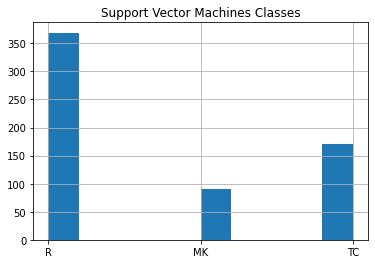

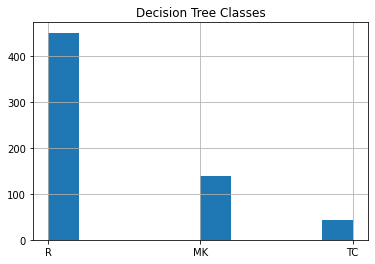

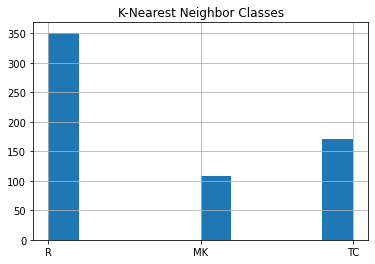

In [683]:
plt.figure()
svc_data[svc_data["IsUser"] == True]["Label"].hist()
plt.title('Support Vector Machines Classes')
plt.figure()
dt_data[dt_data["IsUser"] == True]["Label"].hist()
plt.title('Decision Tree Classes')
plt.figure()
knn_data[knn_data["IsUser"] == True]["Label"].hist()
plt.title('K-Nearest Neighbor Classes')
plt.show()